In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil

%matplotlib inline
%load_ext autoreload
%autoreload 2

# first: check Mazevet+2020 hydrogen E column against CMS19 hydrogen U column to make sure there isn't some arbitrary offset happening

In [46]:
maz = meos.mazevet2022table("./CEPAM/mazevet2020/H-Table-Tristan-Yamila.dat") # "original one sent by Mazevet", i.e. hasn't been put into CEPAM format yet. 
                                                                              # Note there are some NaNs in the meos object log10S column because some of the S values are negative in the original table.
CMS19_H_Trho = meos.CMStable("./2021_chabrier+_tables/TABLE_H_Trho_v1")

# both of these tables use T and rho as their grid coordinates
# mazevet ranges from log10T   =  2.1 to log10T   = 4.9 in steps of deltalog10T  ~= 0.1 (not perfect)
#                     log10rho = -9.0 to log10rho = 1.0 in steps of deltalog10rho = 0.01
#   CMS19 ranges from log10T   =  2.0 to log10T   = 8.0 in steps of deltalog10T   = 0.05
#                     log10rho = -8.0 to log10rho = 6.0 in steps of deltalog10rho = 0.05

print(np.unique(maz.eosData[:,0]))
print(np.unique(CMS19_H_Trho.eosData[:,0]))

[2.11394335 2.21404868 2.31386722 2.41396997 2.51388319 2.61394748
 2.71391035 2.81391442 2.91391976 3.01393212 3.11394335 3.21394255
 3.31395154 3.41393649 3.51394969 3.61394748 3.71394392 3.81394108
 3.91394094 4.01394474 4.11394335 4.21394255 4.31394311 4.41394318
 4.51394304 4.61394325 4.71394308 4.81394308 4.91394359]
[2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65
 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35
 3.4  3.45 3.5  3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05
 4.1  4.15 4.2  4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75
 4.8  4.85 4.9  4.95 5.   5.05 5.1  5.15 5.2  5.25 5.3  5.35 5.4  5.45
 5.5  5.55 5.6  5.65 5.7  5.75 5.8  5.85 5.9  5.95 6.   6.05 6.1  6.15
 6.2  6.25 6.3  6.35 6.4  6.45 6.5  6.55 6.6  6.65 6.7  6.75 6.8  6.85
 6.9  6.95 7.   7.05 7.1  7.15 7.2  7.25 7.3  7.35 7.4  7.45 7.5  7.55
 7.6  7.65 7.7  7.75 7.8  7.85 7.9  7.95 8.  ]


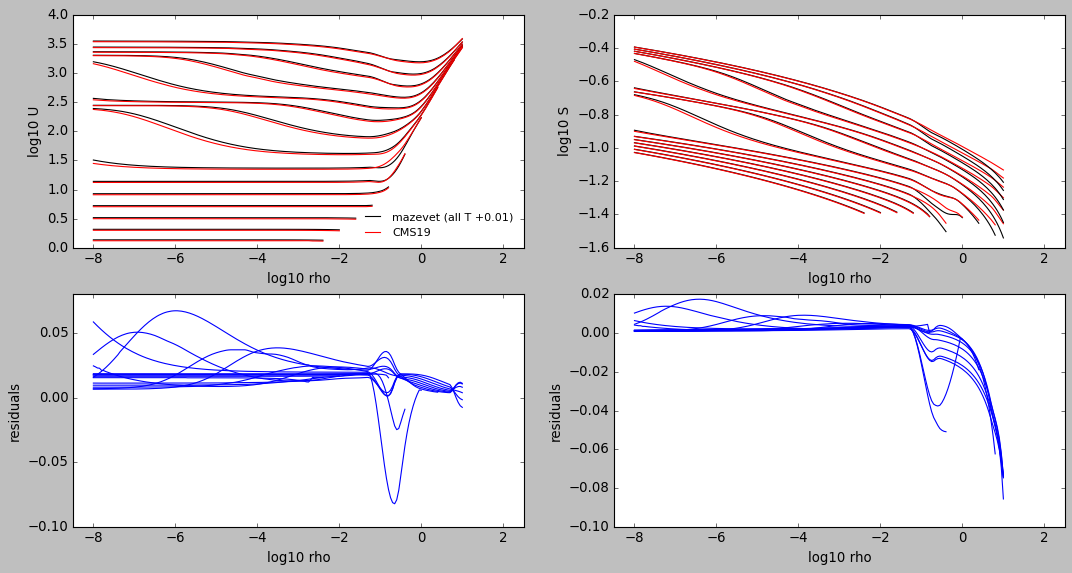

In [68]:
# compare isotherms
allowedMask_maz = ~meos.boundary_mask_rhoT(maz) & ~meos.boundary_mask_PT(maz)
allowedMask_cms = ~meos.boundary_mask_rhoT(CMS19_H_Trho) & ~meos.boundary_mask_PT(CMS19_H_Trho)
    
fig, axes = plt.subplots(2,2,figsize=(16,8))

isotherms = np.arange(2.1,5.0,0.2)
isotherms = np.round(isotherms, 1)

for i, T in enumerate(isotherms):
    mazMask =  (np.round(maz.log10Tgrid,1) == T) & (maz.log10rhogrid >= -8.0)  & (maz.log10rhogrid <= 1.0) & allowedMask_maz
    cmsMask =  (CMS19_H_Trho.log10Tgrid == T) & (CMS19_H_Trho.log10rhogrid >= -8.0) & (CMS19_H_Trho.log10rhogrid <= 1.0) & allowedMask_cms

    if i==0:
        axes[0,0].plot(maz.log10rhogrid[mazMask][::5], maz.log10Ugrid[mazMask][::5], 'k-', label='mazevet (all T +0.01)')
        axes[0,0].plot(CMS19_H_Trho.log10rhogrid[cmsMask], CMS19_H_Trho.log10Ugrid[cmsMask], 'r-', label='CMS19')
    else:
        axes[0,0].plot(maz.log10rhogrid[mazMask][::5], maz.log10Ugrid[mazMask][::5], 'k-')
        axes[0,0].plot(CMS19_H_Trho.log10rhogrid[cmsMask], CMS19_H_Trho.log10Ugrid[cmsMask], 'r-')
    axes[1,0].plot(maz.log10rhogrid[mazMask][::5], maz.log10Ugrid[mazMask][::5]- CMS19_H_Trho.log10Ugrid[cmsMask], 'b-')
    
    axes[0,1].plot(maz.log10rhogrid[mazMask][::5], maz.log10Sgrid[mazMask][::5], 'k-')
    axes[0,1].plot(CMS19_H_Trho.log10rhogrid[cmsMask], CMS19_H_Trho.log10Sgrid[cmsMask], 'r-')
    axes[1,1].plot(maz.log10rhogrid[mazMask][::5], maz.log10Sgrid[mazMask][::5] - CMS19_H_Trho.log10Sgrid[cmsMask], 'b-')

for ax in np.ravel(axes):
    ax.set_xlim(-8.5, 2.5)
    ax.set_xlabel('log10 rho')
for ax in axes[1]:
    ax.set_ylabel('residuals')
axes[0,0].set_ylabel('log10 U')
axes[0,0].legend(loc='best',fontsize=10,frameon=False)

axes[0,1].set_ylabel('log10 S')
plt.show()

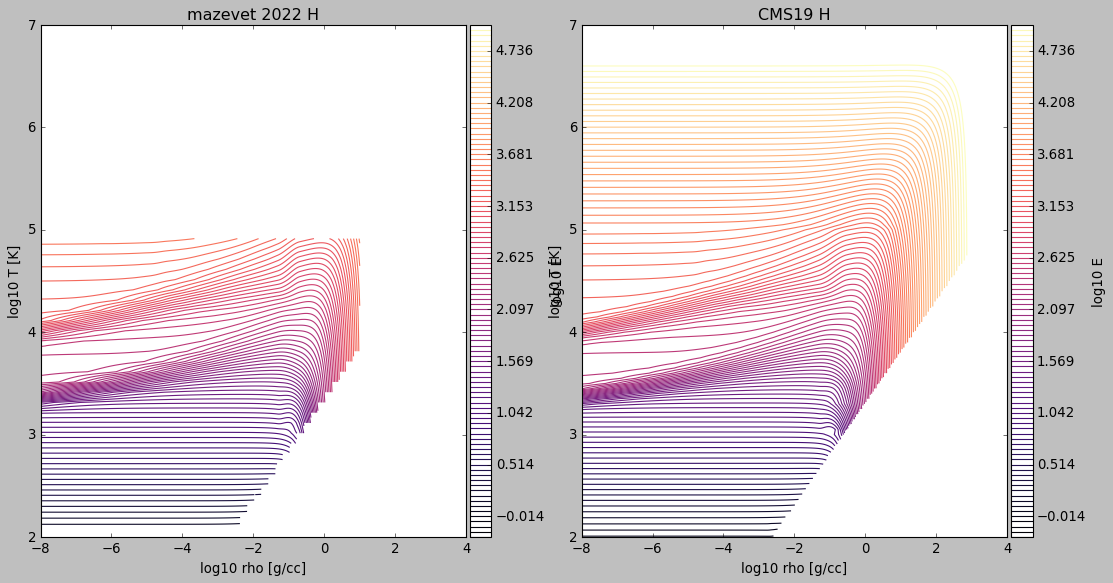

In [50]:
# compare whole landscape of energy levels
Elevels = np.linspace(-0.225, 5.,100)
Emin = -0.225
Emax = 5.

fig, axes = plt.subplots(1,2,figsize=(16,8))

tables = [maz, CMS19_H_Trho]
for j, table in enumerate(tables):
    # masked arrays work a bit backwards--if mask == True, then that value is masked, i.e. set to np.nan
    allowedMask = ~meos.boundary_mask_rhoT(table) & ~meos.boundary_mask_PT(table)
    
    plot_rho = np.ma.array(table.log10rhogrid, mask=~allowedMask, fill_value = np.nan)
    plot_T = np.ma.array(table.log10Tgrid, mask=~allowedMask, fill_value = np.nan)
    plot_U = np.ma.array(table.log10Ugrid, mask=~allowedMask, fill_value = np.nan)
    plot_S = np.ma.array(table.log10Sgrid, mask=~allowedMask, fill_value = np.nan)
    plot_P = np.ma.array(table.log10Pgrid, mask=~allowedMask, fill_value = np.nan)

    divider = make_axes_locatable(axes[j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cs = axes[j].contour(plot_rho, plot_T, plot_U, levels=Elevels, cmap='magma',alpha=1, vmin=Emin, vmax=Emax)
    #cs = axes[j].scatter(plot_rho, plot_T, c=plot_U, s=1, edgecolor='None', cmap='magma',alpha=1, vmin=Emin, vmax=Emax)
    fig.colorbar(cs, cax=cax, orientation='vertical',label='log10 E')
    
for ax in axes:
    ax.set_ylabel('log10 T [K]')
    ax.set_xlabel('log10 rho [g/cc]')
    ax.set_xlim(-8,4)
    ax.set_ylim(2,7)
axes[0].set_title('mazevet 2022 H')
axes[1].set_title('CMS19 H')
plt.show()


# check to see if CEPAM's version of the CMS19 tables have already been interpolated in any way

In [70]:
CEPAM_CMS19_H = meos.CEPAMtable("./CEPAM/CMS19/Chabrier2019-H.csv")
CEPAM_CMS19_He = meos.CEPAMtable("./CEPAM/CMS19/Chabrier2019-He.csv")

CMS19_H = meos.CMStable("./2021_chabrier+_tables/TABLE_H_TP_v1")
CMS19_He = meos.CMStable("./2021_chabrier+_tables/TABLE_HE_TP_v1")


(53361, 10)
[[ 2.        -9.        -9.        ...  0.300487   0.0941121  0.5      ]
 [ 2.        -8.95      -9.        ...  0.228563   0.296108   0.5      ]
 [ 2.        -8.9       -8.61167   ...  0.173909  -1.09326    0.5      ]
 ...
 [ 8.        12.9        6.35287   ...  0.108515   0.0994074  0.366714 ]
 [ 8.        12.95       6.40735   ...  0.0809882  0.156374   0.351826 ]
 [ 8.        13.         6.4666    ...  0.046822   0.218998   0.333358 ]]
(53361, 4)
[[ 2.      -9.      -9.      -1.24587]
 [ 2.      -8.95    -9.      -1.27114]
 [ 2.      -8.9     -8.61167 -1.28916]
 ...
 [ 8.      12.9      6.35287 -1.63199]
 [ 8.      12.95     6.40735 -1.63809]
 [ 8.      13.       6.4666  -1.64471]]


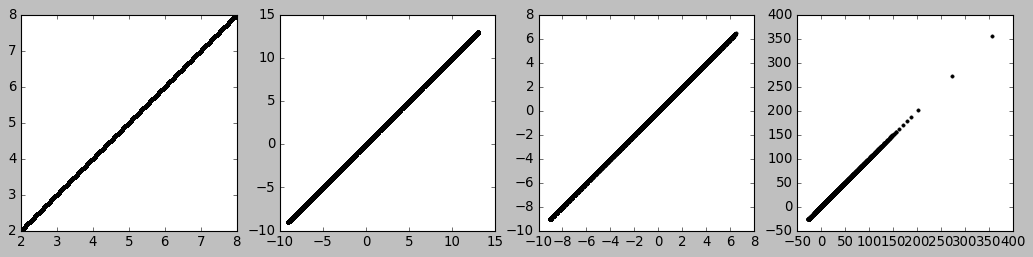

[2. 2. 2. ... 8. 8. 8.]
[2. 2. 2. ... 8. 8. 8.]


In [89]:
print(np.shape(CMS19_He.eosData))
print(CMS19_He.eosData)
print(np.shape(CEPAM_CMS19_He.eosData))
print(CEPAM_CMS19_He.eosData)

fig, axes = plt.subplots(1,4,figsize=(16,6))
for i in range(3):
    axes[i].plot(CMS19_He.eosData[:,i], CEPAM_CMS19_He.eosData[:,i], 'k.')
#CEPAM doesn't have an internal energy column, so skip to entropy
axes[3].plot(CMS19_He.eosData[:,4], CEPAM_CMS19_He.eosData[:,3], 'k.')
for ax in axes:
    ax.set_aspect('equal')
plt.show()

print(CMS19_He.eosData[:,0])
print(CEPAM_CMS19_He.eosData[:,0])

# lastly check if CEPAM's T, P, rho, S columns for mazevet 2022 are the same as in that original table (has there been any interpolation or anything?)

In [91]:
maz = meos.mazevet2022table("./CEPAM/mazevet2020/H-Table-Tristan-Yamila.dat")
CEPAM_maz = meos.CEPAMtable("./CEPAM/mazevet2020/Mazevet2020-H.csv")

In [105]:
print(10**2.11394335)

129.99999930948056


In [122]:
print(np.shape(maz.eosData)) 
print(np.shape(CEPAM_maz.eosData))

print(np.unique(maz.eosData[:,4])[1:]-np.unique(maz.eosData[:,4])[0:-1])
print(len(np.unique(maz.eosData[:,4])))
print(np.unique(maz.eosData[:,4]))
print(np.unique(CEPAM_maz.eosData[:,3])[1:]-np.unique(CEPAM_maz.eosData[:,3])[0:-1])
print(len(np.unique(CEPAM_maz.eosData[:,3])))
print(np.unique(CEPAM_maz.eosData[:,3]))

(29029, 5)
(4031, 4)
[0.13897141 0.23008709 0.01093408 ... 0.00037293 0.0003726         nan]
28955
[-4.00849903 -3.86952762 -3.63944054 ... -0.35393997 -0.35356736
         nan]
[0.03391552 0.11322736 0.00039578 ... 0.00280666 0.00281239 0.00290298]
4023
[-4.01712322 -3.9832077  -3.86998034 ... -0.35425854 -0.35144615
 -0.34854317]


In [124]:
29*1001

29029